#### Analyzing Neural Time Series Data
Python code for Chapter 23 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [37]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import fftconvolve, firls, filtfilt
from scipy.fftpack import fft, ifft
from mne.viz import plot_topomap
from mne.channels import make_standard_montage
from mne import create_info
from mne.io import RawArray
from mne.time_frequency import tfr_morlet

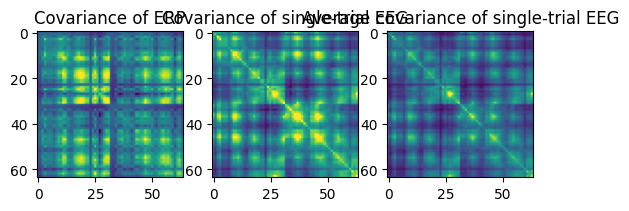

In [16]:
# Figure 23.2: Covariance of ERP and single-trial EEG

# Load sample data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Compute ERP
erp = np.mean(EEG['data'], axis=2)

# Subtract mean and compute covariance
erp = erp - np.mean(erp, axis=1, keepdims=True)
covar = np.dot(erp, erp.T) / (EEG['pnts'][0][0] - 1)

# Plot covariance of ERP
plt.subplot(131)
plt.imshow(covar, aspect='equal', clim=[-1, 5])
plt.title('Covariance of ERP')

# One covariance of all timepoints
eeg = np.reshape(EEG['data'], (EEG['nbchan'][0][0], EEG['pnts'][0][0] * EEG['trials'][0][0]), 'F')
eeg = eeg - np.mean(eeg, axis=1, keepdims=True)
covar = np.dot(eeg, eeg.T) / (len(eeg) - 1)

# Plot covariance of single-trial EEG
plt.subplot(132)
plt.imshow(covar, aspect='equal', clim=[20, 150])
plt.title('Covariance of single-trial EEG')

# Average single-trial covariances
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= i

# Plot average covariance of single-trial EEG
plt.subplot(133)
plt.imshow(covar, aspect='equal', clim=[20, 150])
plt.title('Average covariance of single-trial EEG')
plt.show()

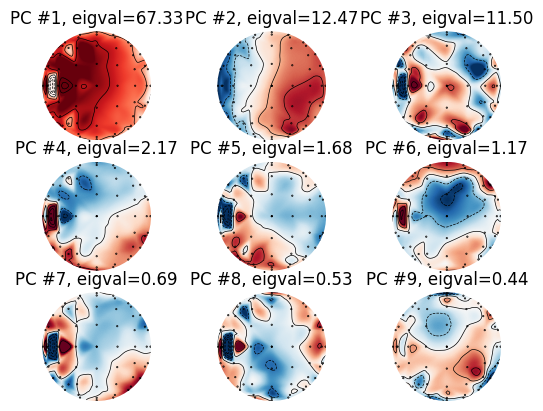

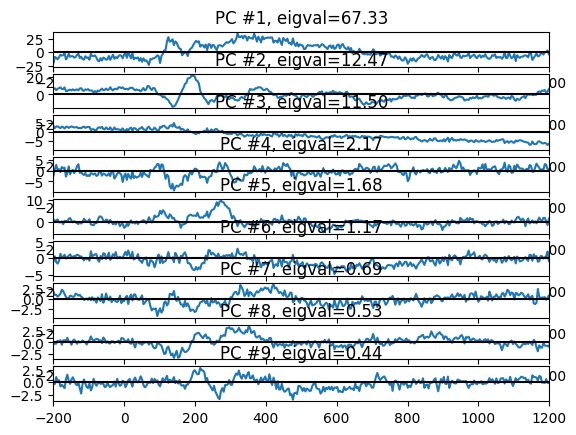

In [21]:
# Figure 23.3: Principle Components Analysis (PCA) of ERP

# Compute covariance of ERP
erp = np.mean(EEG['data'], axis=2)
erp = erp - np.mean(erp, axis=1, keepdims=True)
covar = np.dot(erp, erp.T) / (EEG['pnts'][0][0] - 1)

# PCA via eigenvalue decomposition
eigvals, pc = np.linalg.eig(covar)
pc = pc[:, np.argsort(-eigvals)]
eigvals = np.sort(eigvals)[::-1]
eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

chanlocs = np.array([[x[0][0], y[0][0]] for x, y in zip(EEG['chanlocs'][0]['X'], EEG['chanlocs'][0]['Y'])])

# Plot the first 9 principal components
for i in range(9):
    plt.figure(102)
    ax = plt.subplot(3, 3, i + 1)
    plot_topomap(pc[:, i], chanlocs, axes=ax, show=False)
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.2f}')

    plt.figure(101)
    plt.subplot(9, 1, i + 1)
    plt.plot(EEG['times'][0], pc[:, i].T @ erp)
    plt.axhline(0, color='k')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.2f}')
plt.show()

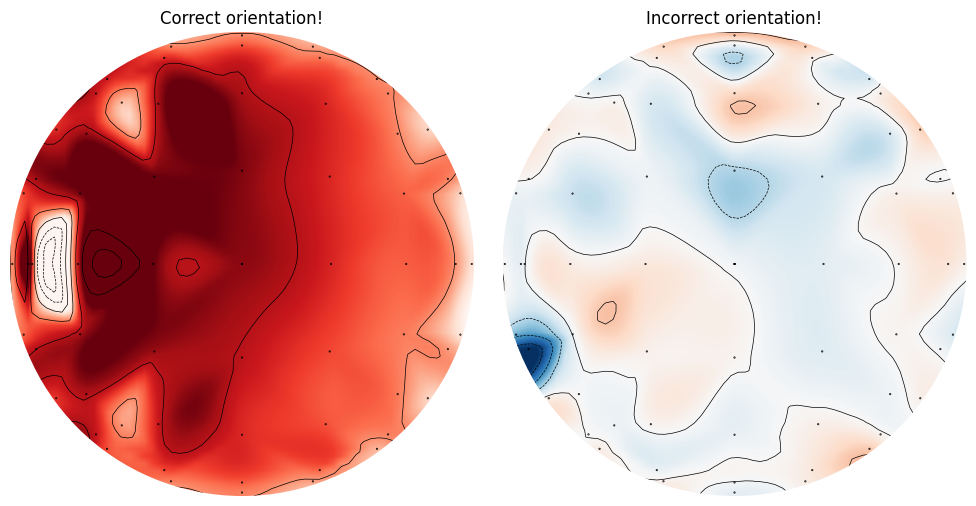

In [26]:
# Tangent: Ensuring correct orientation of the PC matrix

# Assuming 'pc' is the principal component matrix obtained from previous PCA
# and 'ch_xy' contains the 2D coordinates of the channel locations

# Plot the first principal component to ensure correct orientation
plt.figure(figsize=(10, 5))

# Correct orientation
ax = plt.subplot(121)
plot_topomap(pc[:, 0], pos=chanlocs, axes=ax, show=False)
plt.title('Correct orientation!')

# Incorrect orientation
ax = plt.subplot(122)
plot_topomap(pc[0, :], pos=chanlocs, axes=ax, show=False)
plt.title('Incorrect orientation!')

plt.tight_layout()
plt.show()

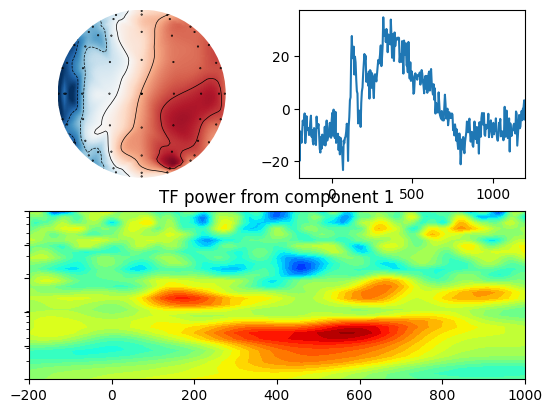

In [43]:
# Figure 23.4: Time-frequency power from a PCA component

pcanum = 1 # 0 for panel A; 1 for panel B

# Define wavelet parameters
min_freq = 2
max_freq = 80
num_frex = 30
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
frex = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
s = np.logspace(np.log10(3), np.log10(10), num_frex) / (2 * np.pi * frex)

# Define convolution parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = 2 ** int(np.ceil(np.log2(n_convolution)))
half_of_wavelet_size = (n_wavelet - 1) // 2

# Project the EEG data onto the chosen principal component for each trial
pcadata = np.zeros((EEG['pnts'][0][0], EEG['trials'][0][0]))
for i in range(EEG['trials'][0][0]):
    # Subtract the mean from each channel's data for the current trial
    eeg_trial = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    # Calculate the PCA scores (projections) for the chosen component
    pcadata[:, i] = np.dot(pc[:, pcanum-1].T, eeg_trial)

# Get FFT of data
eegfft = fft(np.reshape(pcadata, (1, EEG['pnts'][0][0] * EEG['trials'][0][0]), 'F'), n_conv_pow2)

# Initialize
eegpower = np.zeros((num_frex, EEG['pnts'][0][0]))  # frequencies X time X trials

baselinetime = [-500, -200]
baseidx = np.searchsorted(EEG['times'][0], baselinetime)

# Loop through frequencies and compute synchronization
for fi in range(num_frex):
    wavelet = fft(np.exp(2 * 1j * np.pi * frex[fi] * time) * np.exp(-time ** 2 / (2 * (s[fi] ** 2))), n_conv_pow2)
    eegconv = ifft(wavelet * eegfft)[0]
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    temppower = np.mean(np.abs(np.reshape(eegconv, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')) ** 2, axis=1)
    eegpower[fi, :] = 10 * np.log10(temppower / np.mean(temppower[baseidx[0]:baseidx[1]]))

# Plotting the results
ax = plt.subplot(221)
plot_topomap(pc[:, pcanum], chanlocs, axes=ax, show=False)
plt.subplot(222)
plt.plot(EEG['times'][0], np.mean(pcadata, axis=1))
plt.xlim([-200, 1200])

plt.subplot(212)
plt.contourf(EEG['times'][0], frex, eegpower, 40, cmap='jet')
plt.clim([-3, 3])
plt.xlim([-200, 1000])
plt.yscale('log')
plt.yticks(np.logspace(np.log10(min_freq), np.log10(max_freq), 6))
plt.title(f'TF power from component {pcanum}')
plt.show()

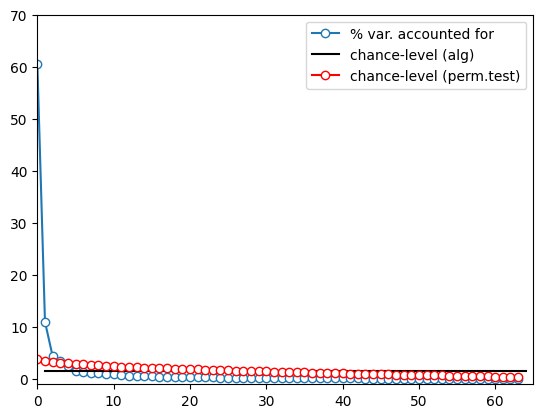

In [46]:
# Figure 23.5: Eigenvalues as percent variance accounted for

# Recompute PCA
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = EEG['data'][:, :, i] - np.mean(EEG['data'][:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= i
eigvals, pc = np.linalg.eig(covar)
eigvals = 100 * np.sort(eigvals)[::-1] / np.sum(eigvals)  # Convert to percent change

# Plot eigenvalues as percent variance accounted for
plt.plot(eigvals, '-o', markerfacecolor='w')
plt.ylim([-1, 70])
plt.xlim([0, 65])

# Amount of variance expected by chance, computed analytically
plt.plot([1, EEG['nbchan'][0][0]], [100 / EEG['nbchan'][0][0]] * 2, 'k')

# Amount of variance expected by chance, computed based on random data
nperms = 1000
permeigvals = np.zeros((nperms, EEG['nbchan'][0][0]))
for permi in range(nperms):
    # Randomize ERP time points within each channel
    randdat = np.copy(erp)
    for ch in range(erp.shape[0]):
        np.random.shuffle(randdat[ch, :])
    
    # Compute covariance matrix of the randomized data
    covar = np.dot(randdat, randdat.T) / (EEG['pnts'][0][0] - 1)
    
    # Perform eigenvalue decomposition
    eigvals, pc = np.linalg.eig(covar)
    eigvals = np.sort(eigvals)[::-1]  # Sort eigenvalues in descending order
    permeigvals[permi, :] = 100 * eigvals / np.sum(eigvals)  # Convert to percent change

plt.plot(np.mean(permeigvals, axis=0), 'r-o', markerfacecolor='w')
plt.legend(['% var. accounted for', 'chance-level (alg)', 'chance-level (perm.test)'])
plt.show()

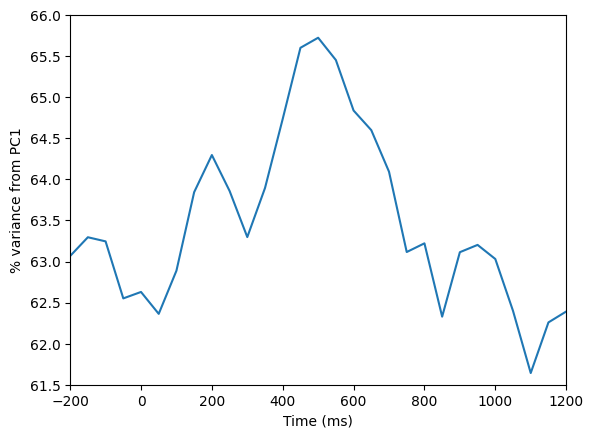

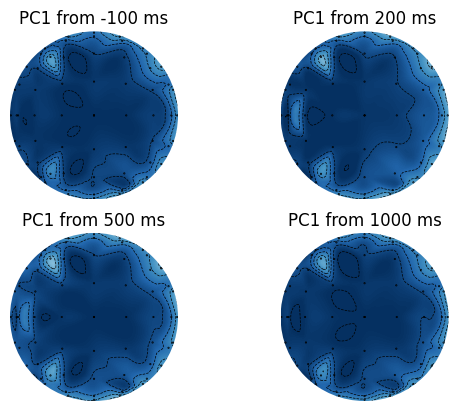

In [59]:
# Figure 23.6: Temporally localized PCA

# Define parameters
whichcomp = 1  # 1 for panel A; 2 for panel B
centertimes = np.arange(-200, 1201, 50)
timewindow = 200  # ms on either side of center times
maptimes = np.array([-100, 200, 500, 1000] if whichcomp == 1 else [0, 300, 750, 1000])
clim = [0.08, 0.15] if whichcomp == 1 else [-0.2, 0.2]

# Initialize variables
pcvariance = np.zeros(len(centertimes))
firstpcas = np.zeros((len(centertimes), EEG['nbchan'][0][0]))
timesidx = np.argmin(np.abs(EEG['times'][0] - centertimes[:, None]), axis=1)
timewinidx = round(timewindow / (1000 / EEG['srate'][0][0]))
mapsidx = np.argmin(np.abs(centertimes - maptimes[:, None]), axis=1)

# Perform temporally localized PCA
for ti, center_time in enumerate(centertimes):
    # Temporally localized covariance
    covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
    for i in range(EEG['trials'][0][0]):
        eeg = EEG['data'][:, timesidx[ti] - timewinidx:timesidx[ti] + timewinidx, i]
        eeg = eeg - np.mean(eeg, axis=1, keepdims=True)
        covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
    covar /= i
    
    # PCA via eigenvalue decomposition
    eigvals, pc = np.linalg.eig(covar)
    pc = pc[:, np.argsort(-eigvals)]
    eigvals = np.sort(eigvals)[::-1]
    eigvals = 100 * eigvals / np.sum(eigvals)  # Convert to percent change
    
    pcvariance[ti] = eigvals[whichcomp - 1]
    firstpcas[ti, :] = pc[:, whichcomp - 1]

# Plot variance over time
plt.plot(centertimes, pcvariance)
plt.xlim([-200, 1200])
plt.ylim([61.5, 66])
plt.xlabel('Time (ms)')
plt.ylabel(f'% variance from PC{whichcomp}')
plt.show()

# Plot topomaps at specified times
for i, maptime in enumerate(maptimes):
    ax = plt.subplot(int(np.ceil(len(maptimes) / np.ceil(np.sqrt(len(maptimes))))), int(np.ceil(np.sqrt(len(maptimes)))), i + 1)
    plot_topomap(firstpcas[mapsidx[i], :], chanlocs, axes=ax, show=False)
    plt.title(f'PC{whichcomp} from {maptime} ms')
plt.show()

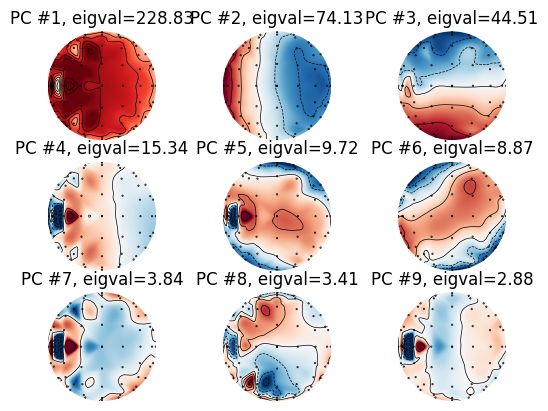

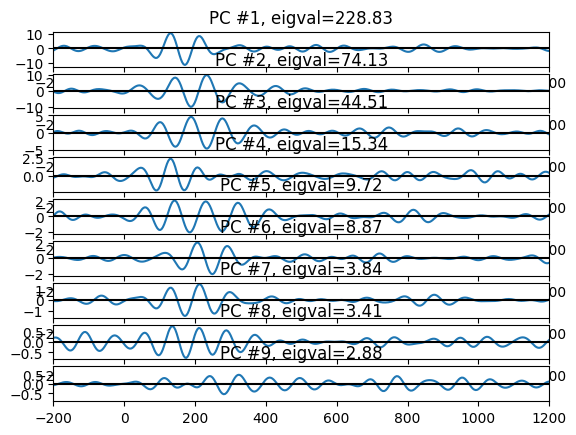

In [64]:
# Figure 23.7: PCA after band-pass filtering the data

# Filter parameters
center_freq = 12  # in Hz
filter_frequency_spread = 3  # Hz +/- the center frequency
transition_width = 0.2

# Construct filter kernel
nyquist = EEG['srate'][0][0] / 2
filter_order = round(3 * (EEG['srate'][0][0] / (center_freq - filter_frequency_spread)))
ffrequencies = [0, (1 - transition_width) * (center_freq - filter_frequency_spread), (center_freq - filter_frequency_spread), (center_freq + filter_frequency_spread), (1 + transition_width) * (center_freq + filter_frequency_spread), nyquist] / nyquist
idealresponse = [0, 0, 1, 1, 0, 0]
filterweights = firls(filter_order, ffrequencies, idealresponse)

# Filter the data
filter_result = filtfilt(filterweights, 1, np.reshape(EEG['data'], (EEG['nbchan'][0][0], EEG['pnts'][0][0] * EEG['trials'][0][0]), 'F'))
filter_result = np.reshape(filter_result, (EEG['nbchan'][0][0], EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Perform PCA on filtered data
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0]):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= i
eigvals, pc = np.linalg.eig(covar)
pc = pc[:, np.argsort(-eigvals)]

# Plot the first 9 principal components
for i in range(9):
    plt.figure(10)
    ax = plt.subplot(3, 3, i + 1)
    plot_topomap(pc[:, i], chanlocs, axes=ax, show=False)
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.2f}')

    plt.figure(11)
    plt.subplot(9, 1, i + 1)
    plt.plot(EEG['times'][0], pc[:, i].T @ np.mean(filter_result, axis=2))
    plt.axhline(0, color='k')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}, eigval={eigvals[i]:.2f}')
plt.show()

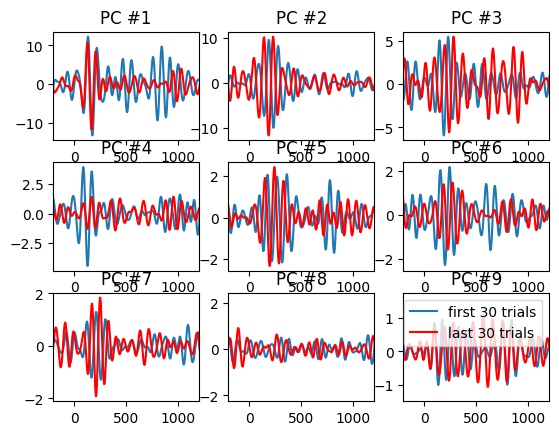

In [65]:
# Figure 23.8: PCA on first and last 30 trials after band-pass filtering

# PCA on first 30 trials
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(30):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= i
eigvals, pc_first = np.linalg.eig(covar)
pc_first = pc_first[:, np.argsort(-eigvals)]

# PCA on last 30 trials
covar = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for i in range(EEG['trials'][0][0] - 29, EEG['trials'][0][0]):
    eeg = filter_result[:, :, i] - np.mean(filter_result[:, :, i], axis=1, keepdims=True)
    covar += np.dot(eeg, eeg.T) / (EEG['pnts'][0][0] - 1)
covar /= 30
eigvals, pc_last = np.linalg.eig(covar)
pc_last = pc_last[:, np.argsort(-eigvals)]

# Plot the first 9 principal components for first and last 30 trials
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(EEG['times'][0], pc_first[:, i].T @ np.mean(filter_result[:, :, :30], axis=2))
    plt.plot(EEG['times'][0], pc_last[:, i].T @ np.mean(filter_result[:, :, -30:], axis=2), 'r')
    plt.xlim([-200, 1200])
    plt.title(f'PC #{i + 1}')
plt.legend(['first 30 trials', 'last 30 trials'])
plt.show()